In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('dark_background')

ds    object
y      int64
dtype: object
                    ds   y
0  2024-04-10 10:00:00   1
1  2024-04-10 11:00:00  23
2  2024-04-10 12:00:00   7
3  2024-04-10 13:00:00   8
4  2024-04-10 14:00:00   7
ds    datetime64[ns]
y              int64
dtype: object


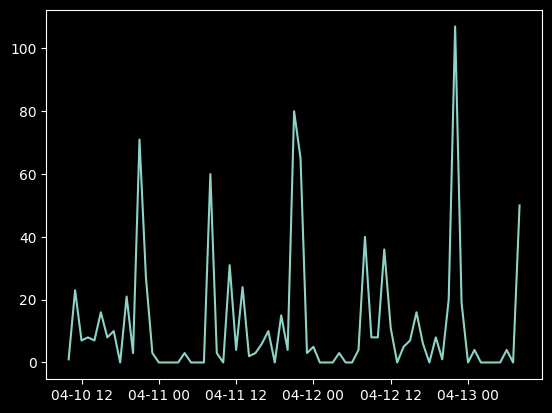

In [11]:
# load the dataset
df = pd.read_csv('282C02BFFFED7102.csv')
df.drop('unique_id', axis = 1, inplace=True)
print(df.dtypes)
print(df.head())

df['ds'] = pd.to_datetime(df['ds'])
print(df.dtypes)
df.set_index('ds', inplace=True) 

plt.plot(df['y'])

In [8]:
#Is the data stationary?
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.2088379284046094  if above 0.05, data is not stationary


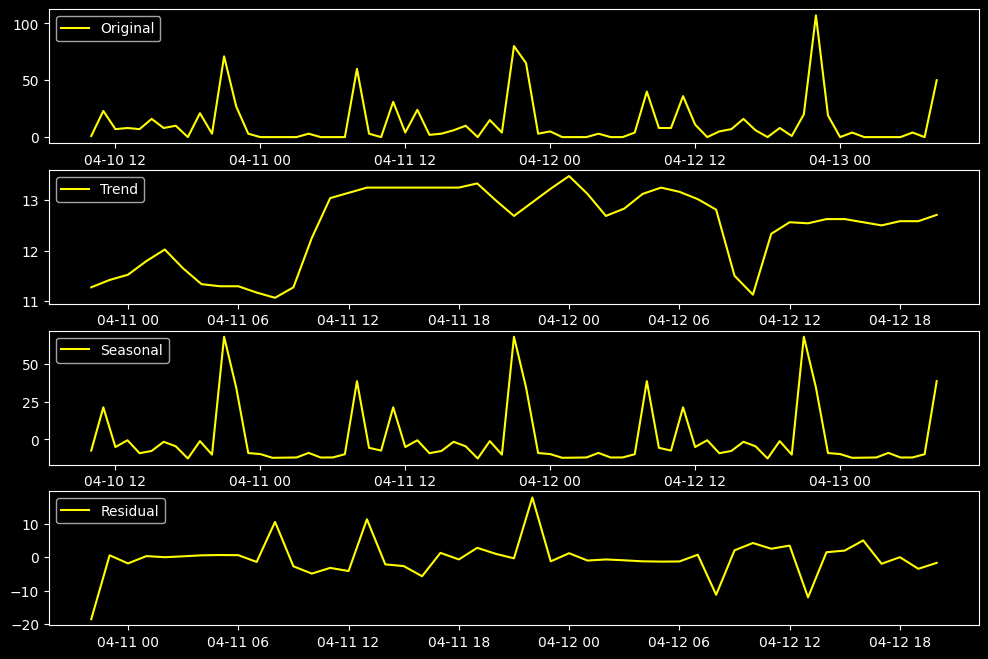

In [12]:
#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['y'],  
                            model ='additive')

#Additive time series:
#Value = Base Level + Trend + Seasonality + Error
#Multiplicative Time Series:
#Value = Base Level x Trend x Seasonality x Error

trend = decomposed.trend
seasonal = decomposed.seasonal #Cyclic behavior may not be seasonal!
residual = decomposed.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['y'], label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

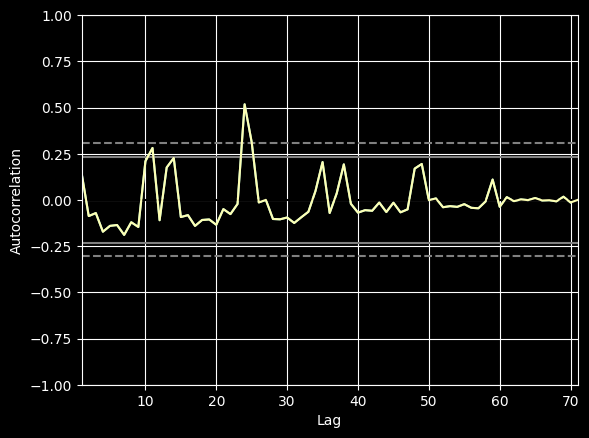

In [13]:
#AUTOCORRELATION
#Autocorrelation is simply the correlation of a series with its own lags.
# Plot lag on x axis and correlation on y axis
#Any correlation above confidence lnes are statistically significant.

from statsmodels.tsa.stattools import acf

acf_144 = acf(df.y, nlags=144)
plt.plot(acf_144)

#Obtain the same but with single line and more info...
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.y) 
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

#A strong positive correlation for lags below 24 (hours)

In [ ]:
#https://youtu.be/TSfdvQ0ARwI
"""

Dataset from: https://www.kaggle.com/rakannimer/air-passengers
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

Stat library: https://www.statsmodels.org/stable/index.html
Need version 0.11 or later..
pip install statsmodels --upgrade

For pmdarima:
pip install pmdarima
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('dark_background')

# load the dataset
df = pd.read_csv('data/AirPassengers.csv')
print(df.dtypes)

df['Month'] = pd.to_datetime(df['Month'])
print(df.dtypes)

df.set_index('Month', inplace=True) 

plt.plot(df['Passengers'])

#Is the data stationary?
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)
#Not stationary...

#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA


#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(df['Passengers'],  
                            model ='additive')

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df, label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()


#We can go through the exercise of making the data stationary and performing ARIMA
#Or let auto_arima provide the best model (e.g. SARIMA) and parameters. 
#Auto arima suggests best model and parameters based on 
#AIC metric (relative quality of statistical models)

from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(df['Passengers'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)           
  
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

#Split data into train and test
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]

# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 


#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Passengers'].plot(legend = True) 


import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

#from sklearn.metrics import r2_score
#score = r2_score(X_test, prediction)
#print("R2 score is: ", score)

#Forecast.. You can re-train on the entire dataset before forecasting
#For now let us use the trained model
# Forecast for the next 3 years 
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='Left corner')
plt.show()

##################
